## import packages

In [1013]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import os
import thresholding

from IPython.display import Image
from IPython.core.display import HTML 

%matplotlib qt
%matplotlib inline

## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration using chessboard images
extract object points and image points for camera calibration

In [1014]:
class calibrate_camera:
    def __init__(self, calibration_img='../camera_cal/calibration*.jpg', matrix_data_path = "..//matrix_data//chessboard_calibrationPoint.p"):
        """
        parameter for camera calibration
        """
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        # need (1) the number of inside corners in x and (2) the number of inside corners in y
        self.objp = np.zeros((6*9,3), np.float32)
        self.objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
        
        # Arrays to store object points and image points from all the images.
        # 3d points in real world space.  ex:array([[ 0.,  0.,  0.],[ 1.,  0.,  0.],[ 2.,  0.,  0.],[ 3.,  0.,  0.],
        self.objpoints = []
        
        # 2d points in image plane. ex: [array([[[ 545.32281494,  343.05032349]],[[ 602.67919922,  342.82681274]], 
        self.imgpoints = []

        # Make a list of calibration images
        self.images = glob.glob(calibration_img)

        # Step through the list and search for chessboard corners
        for fname in self.images:
            img = cv2.imread(fname)
            new_fname = "..//calibrated_img_chessboard//marked_"+ fname.split("\\")[-1]
            # Convert to grayscale
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

            # If found, add object points, image points
            if ret == True:
                self.objpoints.append(self.objp)
                self.imgpoints.append(corners)

                # Draw and display the corners
                img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
                plt.imsave(fname = new_fname, arr =img )
        #         cv2.imshow('img',img)
        #         cv2.waitKey(500)
        # cv2.destroyAllWindows()
        self.chessboard_calibrationPoint = {"objpoints": self.objpoints, "imgpoints": self.imgpoints}
        self.matrix_data_path = matrix_data_path
        
        
        
    def display_category(self):
        img_style = "width: 180px; margin: 0px; float: left; border: 1px solid black;"
        images_list = ''.join([f"<img style='{img_style}' src='{img}' />" for img in self.images])

        display(HTML(images_list))
        
    def read_pickle(self, f_path):
        with open(f_path, 'rb') as handle:
            return pickle.load(handle)

    def write_pickle(self, f_path, data):
        with open(f_path, 'wb') as handle:
            pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [1015]:
cc = calibrate_camera()

In [1016]:
cc.display_category()

In [53]:
write_pickle(matrix_data_path, chessboard_calibrationPoint)

In [55]:
# Read in the saved objpoints and imgpoints
dist_pickle = read_pickle(matrix_data_path)
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

## Read images

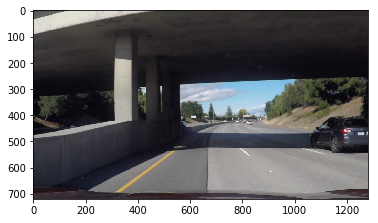

In [1047]:
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [1029]:
import math

row:  4
column:  3


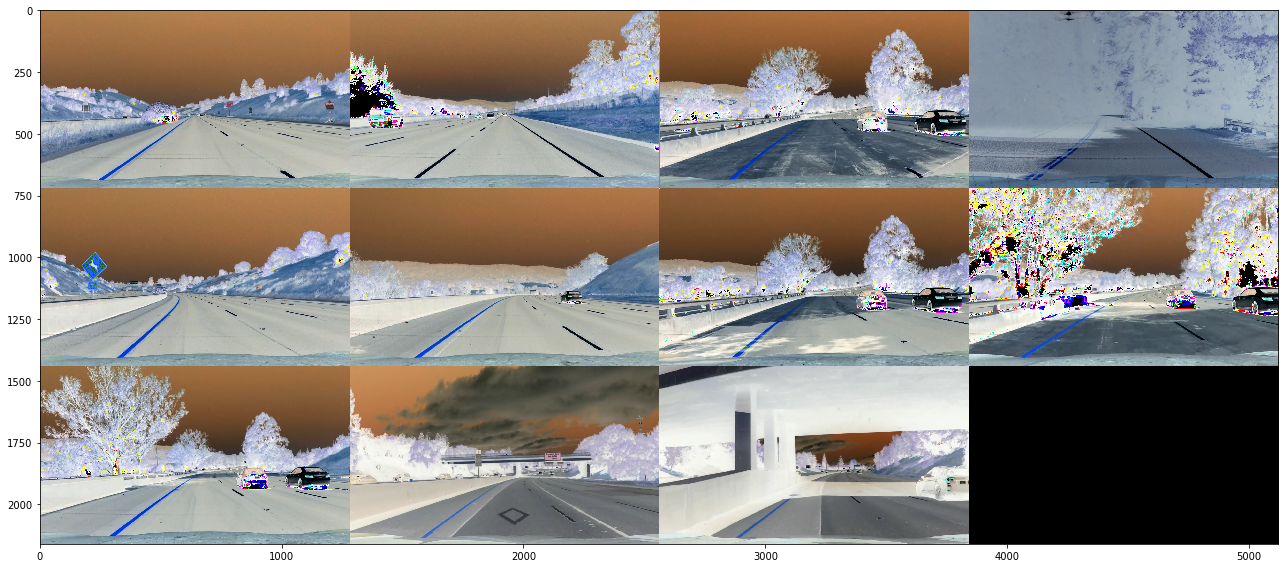

In [1051]:
test_img_path = "..//test_images//*.jpg"
test_imgs = glob.glob(test_img_path)

row_num = 4
col_num = math.ceil(len(test_imgs)/row_num)
print ("row: ",row_num)
print ("column: ",col_num)

RGB_img = np.zeros((720 * col_num, 1280 * row_num, 3))

for i, fname in enumerate(test_imgs):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    RGB_img[720 * (i//row_num):720 * ((i//row_num) + 1),1280 * (i%row_num):1280 * ((i%row_num) + 1),:] = img #cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(figsize=(18, 8))
ax.imshow(RGB_img, aspect='auto')
plt.tight_layout()     

## Get undistorted image

input: distorted image 
output: undistorted image

* Undistort the image using cv2.undistort() with mtx and dist
* Define 4 source points (the outer 4 corners detected in the chessboard pattern)
* Define 4 destination points (must be listed in the same order as src points!)
* Use cv2.getPerspectiveTransform() to get M, the transform matrix
* use cv2.warpPerspective() to apply M and warp your image to a top-down view

ret:1.0298149716172824


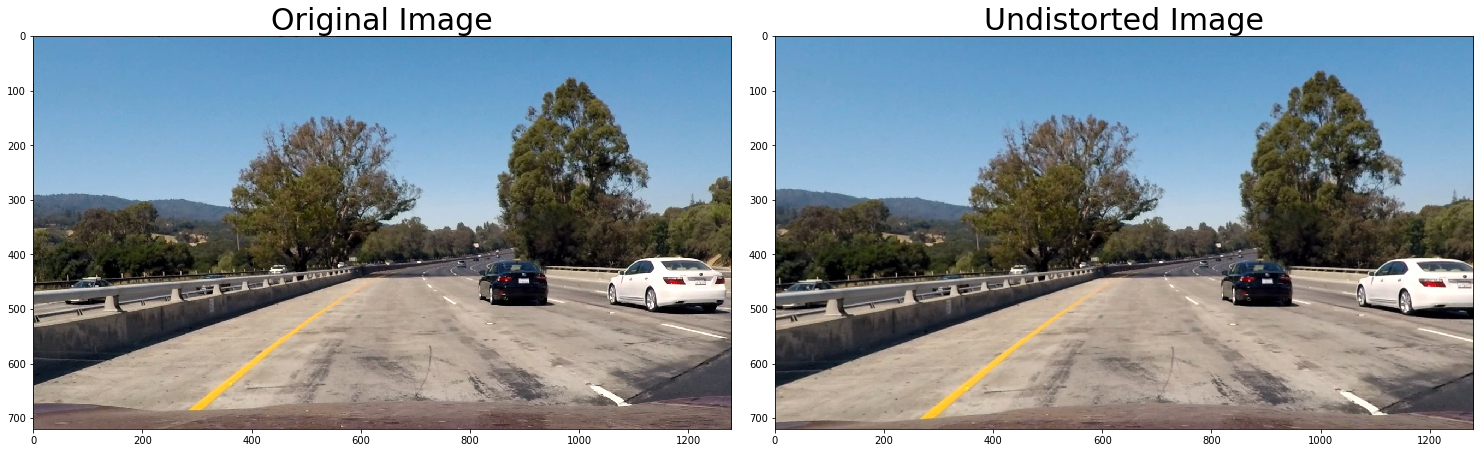

In [268]:
def cal_undistort(img, objpoints, imgpoints):
    """
    1. read an image, object points, and image points
    2. performs the camera calibration, image distortion correction
    3. returns the undistorted image
    """
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    img_corner = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    print ("ret:" + str(ret))
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    # Save the camera calibration result for later use (Ignore about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    write_pickle("..//matrix_data//wide_dist_pickle.p", dist_pickle)

    return undist

cp_img = np.copy(img)
RGB_img = cv2.cvtColor(cp_img, cv2.COLOR_BGR2RGB)

undistorted= cal_undistort(cp_img, objpoints, imgpoints)
undistorted = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(RGB_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [86]:
## perspective transform

In [1053]:
#perspective transform on undistorted images
def perspective_transform(img):
    # Minv: inverse matrix
    size_y, size_x, _ = img.shape
    img_size = (size_x, size_y) 
    
#     color_selector_obj = laneLineDetector()
#     cp_img = np.copy(img)
#     out_image = color_selector_obj.color_filterprocess_image(cp_img)
#     src = color_selector_obj.src_pts
    
    src = np.float32([[(.45*size_x, 0.63*size_y), (.55*size_x, 0.63*size_y)
                     , (0.9*size_x,size_y)
                     , (0.1* size_x,size_y)]])


    # the order is (1)upper left (2)upper right (3) lower right (4) lower left
    dst = np.float32([[0.2*size_x,0]
                     , [0.8*size_x,0]         
                    ,[0.8*size_x,size_y]
                    ,[0.2*size_x,size_y]])
    
    # draw region of interest
    src_img = draw_polygon(img, np.int32(src))
    dst_img = draw_polygon(img, np.int32(dst))
    
    M = cv2.getPerspectiveTransform(src, dst)

    Minv = cv2.getPerspectiveTransform(dst, src)
    
    perspective_img = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)    
    
    reverse_perspective_img = cv2.warpPerspective(perspective_img, Minv, img_size, flags = cv2.INTER_LINEAR)    
    return perspective_img, reverse_perspective_img, Minv, src_img, dst_img

#region of interest
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img, dtype=np.uint8)
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

origin -> undistorted -> perspective image

In [ ]:
perspective_img, reverse_perspective_img, Minv, s_img, t_img = perspective_transform(undistorted)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 10))
f.tight_layout()
ax1.imshow(s_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(t_img)
ax2.set_title('Undistorted Image', fontsize=30)
ax3.imshow(perspective_img)
ax3.set_title('Perspective transformed Image', fontsize=30)
ax4.imshow(reverse_perspective_img)
ax4.set_title('Reverse Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
invvse_img = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)  

In [814]:
def color_of_interest(img, boundary):
    lower, upper = boundary
    # create NumPy arrays from the boundaries
    lower = np.array(lower, dtype = "uint8")
    upper = np.array(upper, dtype = "uint8")

    # find the colors within the specified boundaries and apply
    # the mask
    mask = cv2.inRange(img, lower, upper)
    return cv2.bitwise_and(img, img,  mask= mask)

yellowLine_color_boundary = ([200,170,0], [255, 225, 150])
WhiteLine_color_boundary = ([210,210,210], [255, 255, 255])
yellowLine_img = color_of_interest(perspective_img, yellowLine_color_boundary)
whiteLine_img = color_of_interest(perspective_img, WhiteLine_color_boundary)

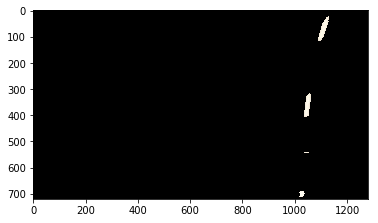

In [815]:
plt.imshow(whiteLine_img)

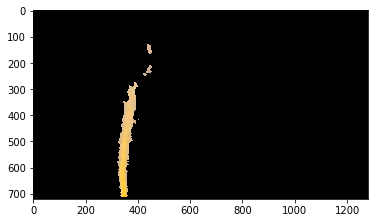

In [816]:
plt.imshow(yellowLine_img)

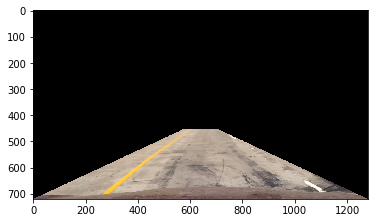

In [801]:
size_y, size_x, _ = undistorted.shape
img_size = (size_x, size_y) 

masked_img = region_of_interest(undistorted
                 , np.int32([[(.55*size_x, 0.63*size_y)
                 , (size_x,size_y)
                 , (0,size_y)
                 ,(.45*size_x, 0.63*size_y)]]))
plt.imshow(masked_img)

## Gradient threshold

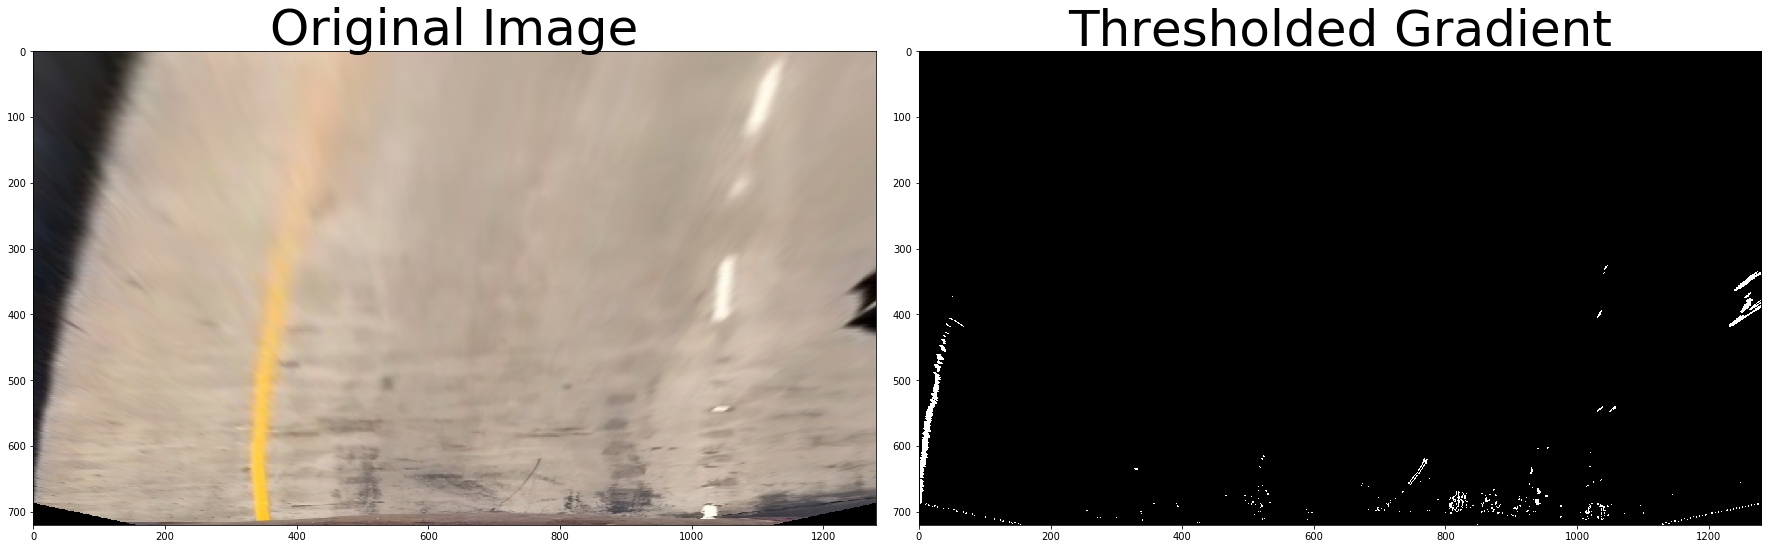

In [822]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient=='y':
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobelx)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))      
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary
    
# Run the function
grad_binary = abs_sobel_thresh(perspective_img, orient='x', thresh_min=40, thresh_max=100)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(perspective_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

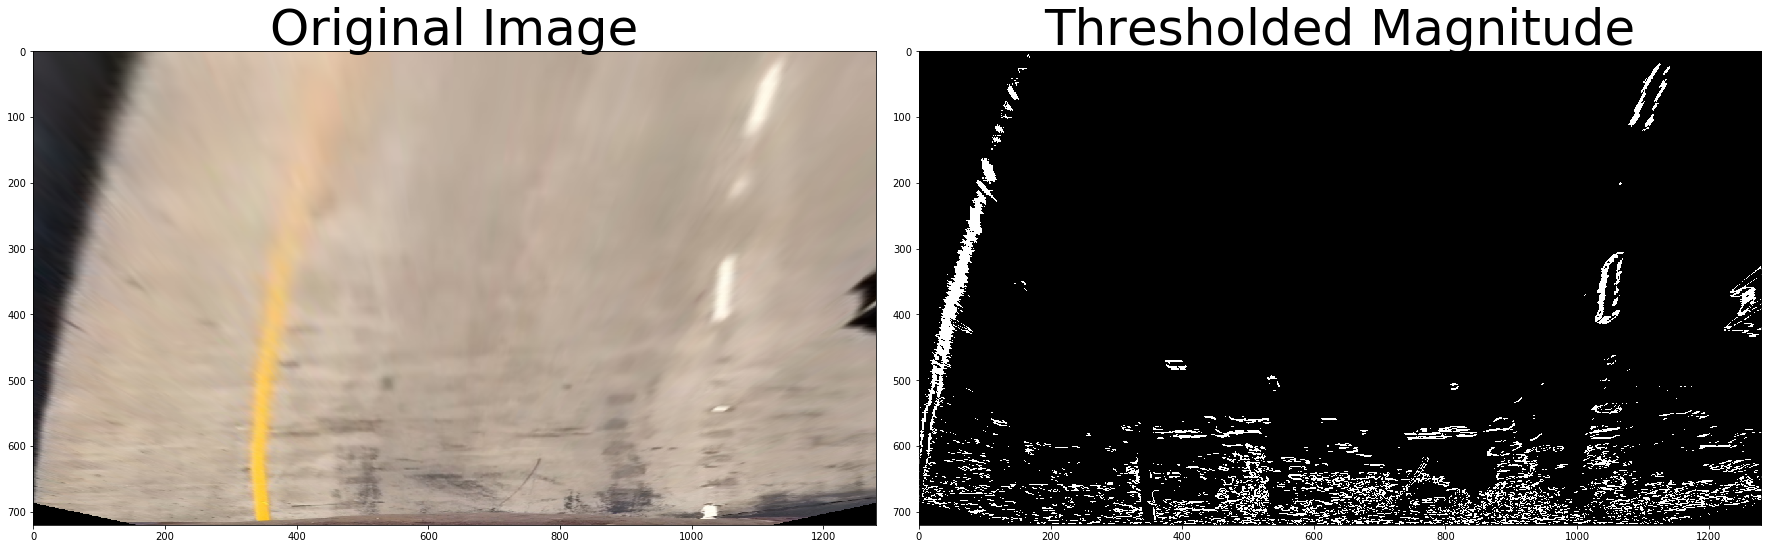

In [835]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)
    

    # 3) Calculate the magnitude 
    magnitude = np.sqrt(np.square(sobelx)+np.square(sobely))
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*magnitude/np.max(magnitude))  
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
#     print(scaled_sobel[650:670,340:370])
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary
    
# Run the function
mag_binary = mag_thresh(perspective_img, sobel_kernel=9, mag_thresh=(10, 20))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(perspective_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Direction of the Gradient

Parameters:	
x1 : array_like, real-valued

y-coordinates.

x2 : array_like, real-valued

x-coordinates. x2 must be broadcastable to match the shape of x1 or vice versa.

Returns:	
angle : ndarray

Array of angles in radians, in the range [-pi, pi].

formula: radians = degrees × π / 180°

ref: https://docs.scipy.org/doc/numpy-1.12.0/reference/generated/numpy.arctan2.html

In [349]:
for i in np.arange(0,195,15):
    print ("degree: {} , radian: {}".format(i, i* np.pi/180))

degree: 0 , radian: 0.0
degree: 15 , radian: 0.2617993877991494
degree: 30 , radian: 0.5235987755982988
degree: 45 , radian: 0.7853981633974483
degree: 60 , radian: 1.0471975511965976
degree: 75 , radian: 1.3089969389957472
degree: 90 , radian: 1.5707963267948966
degree: 105 , radian: 1.8325957145940461
degree: 120 , radian: 2.0943951023931953
degree: 135 , radian: 2.356194490192345
degree: 150 , radian: 2.6179938779914944
degree: 165 , radian: 2.8797932657906435
degree: 180 , radian: 3.141592653589793


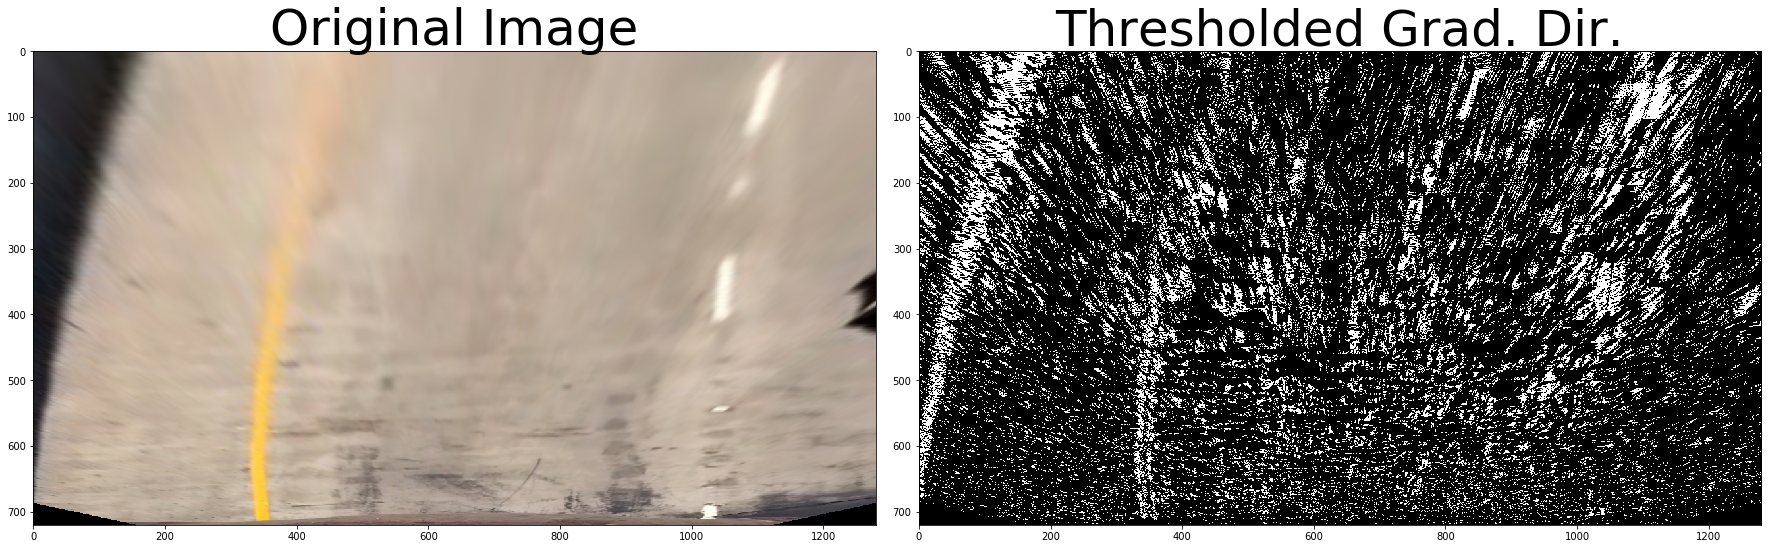

In [820]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_gradient =np.arctan2(abs_sobely, abs_sobelx) 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    sxbinary = np.zeros_like(dir_gradient)
    sxbinary[(dir_gradient >= thresh[0]) & (dir_gradient <= thresh[1])] = 1
    return sxbinary
    
# Run the function
dir_binary = dir_threshold(perspective_img, sobel_kernel=15, thresh=(0.1, 0.6))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(perspective_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [821]:
for i in np.arange(0, 3.14, 0.1):
    new_fname = "..//sobel_images//marked_"+str(i)+".jpg"
    dir_binary = dir_threshold(perspective_img, sobel_kernel=15, thresh=(i, i+0.1))
    plt.imsave(fname = new_fname, arr =dir_binary )

## region of interest

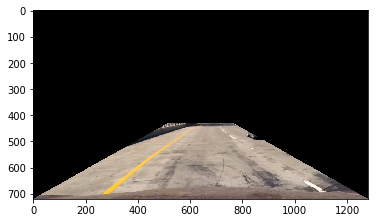

In [457]:
size_y, size_x, _ = undistorted.shape
img_size = (size_x, size_y) 

masked_img = region_of_interest(undistorted
                 , np.int32([[(.6*size_x, 0.6*size_y)
                 , (size_x,size_y)
                 , (0,size_y)
                 ,(.4*size_x, 0.6*size_y)]]))
plt.imshow(masked_img)

## Color thresholding

### HLS

H: 0~179
S：0~255
V：0~255

In [720]:
hls_img = cv2.cvtColor(perspective_img, cv2.COLOR_RGB2HLS)  # cv2.cvtColor(perspective_img, cv2.COLOR_HLS2RGB)

In [724]:
H_img = hls_img[:,:,0]
L_img = hls_img[:,:,1]
S_img = hls_img[:,:,2]

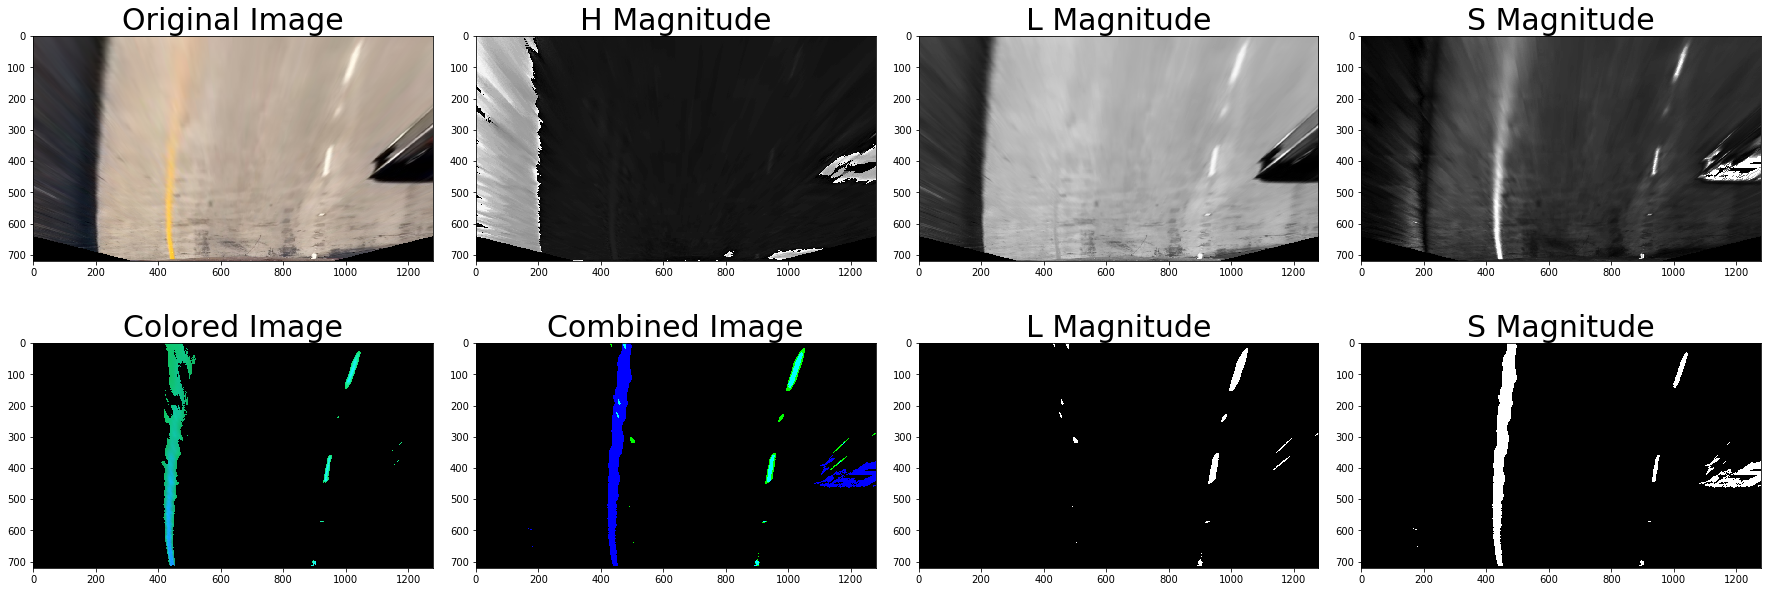

In [791]:
# Plot the result
f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(24, 9))
f.tight_layout()

ax1.imshow(perspective_img)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(H_img, cmap='gray')
ax2.set_title('H Magnitude', fontsize=30)

ax3.imshow(L_img, cmap='gray')
ax3.set_title('L Magnitude', fontsize=30)

ax4.imshow(S_img, cmap='gray')
ax4.set_title('S Magnitude', fontsize=30)

H_binary = np.zeros_like(H_img)

L_thresh = (200, 255)
L_binary = np.zeros_like(L_img)
L_binary[(L_img > L_thresh[0]) & (L_img <= L_thresh[1])] = 1

S_thresh = (120, 255)
S_binary = np.zeros_like(S_img)
S_binary[(S_img > S_thresh[0]) & (S_img <= S_thresh[1])] = 1

# Sobel x
gray = cv2.cvtColor(perspective_img, cv2.COLOR_RGB2GRAY)
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# (1) Combine the two binary thresholds
combined_binary = np.zeros_like(perspective_img[:,:,0])
combined_binary[(L_binary == 1) | (S_binary == 1) | (sxbinary == 1)] = 255

# (2) Colored combined image
filtered_hls_img = np.stack((H_binary, L_binary, S_binary), axis=2) *255

# (3)
lower_HLS = np.array([15, 150, 100])
upper_HLS = np.array([30, 255, 255])
mask_HLS = cv2.inRange(hls_img, lower_HLS, upper_HLS)
mask_HLS_img = cv2.bitwise_and(hls_img,hls_img, mask= mask_HLS)

ax5.imshow(mask_HLS_img);ax5.set_title('Colored Image', fontsize=30);
ax6.imshow(filtered_hls_img);ax6.set_title('Combined Image', fontsize=30);
ax7.imshow(L_binary, cmap='gray');ax7.set_title('L Magnitude', fontsize=30);
ax8.imshow(S_binary, cmap='gray');ax8.set_title('S Magnitude', fontsize=30);plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### HSV

For HSV, Hue range is [0,179], Saturation range is [0,255] and Value range is [0,255].

In [839]:
hsv_img = cv2.cvtColor(perspective_img, cv2.COLOR_RGB2HSV)  # cv2.cvtColor(perspective_img, cv2.COLOR_HSV2RGB)

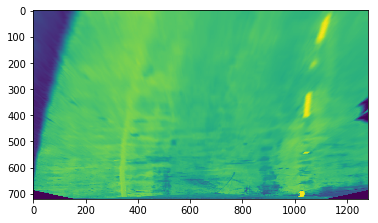

In [931]:
plt.imshow(gray)

In [840]:
H_img = hsv_img[:,:,0]
S_img = hsv_img[:,:,1]
V_img = hsv_img[:,:,2]

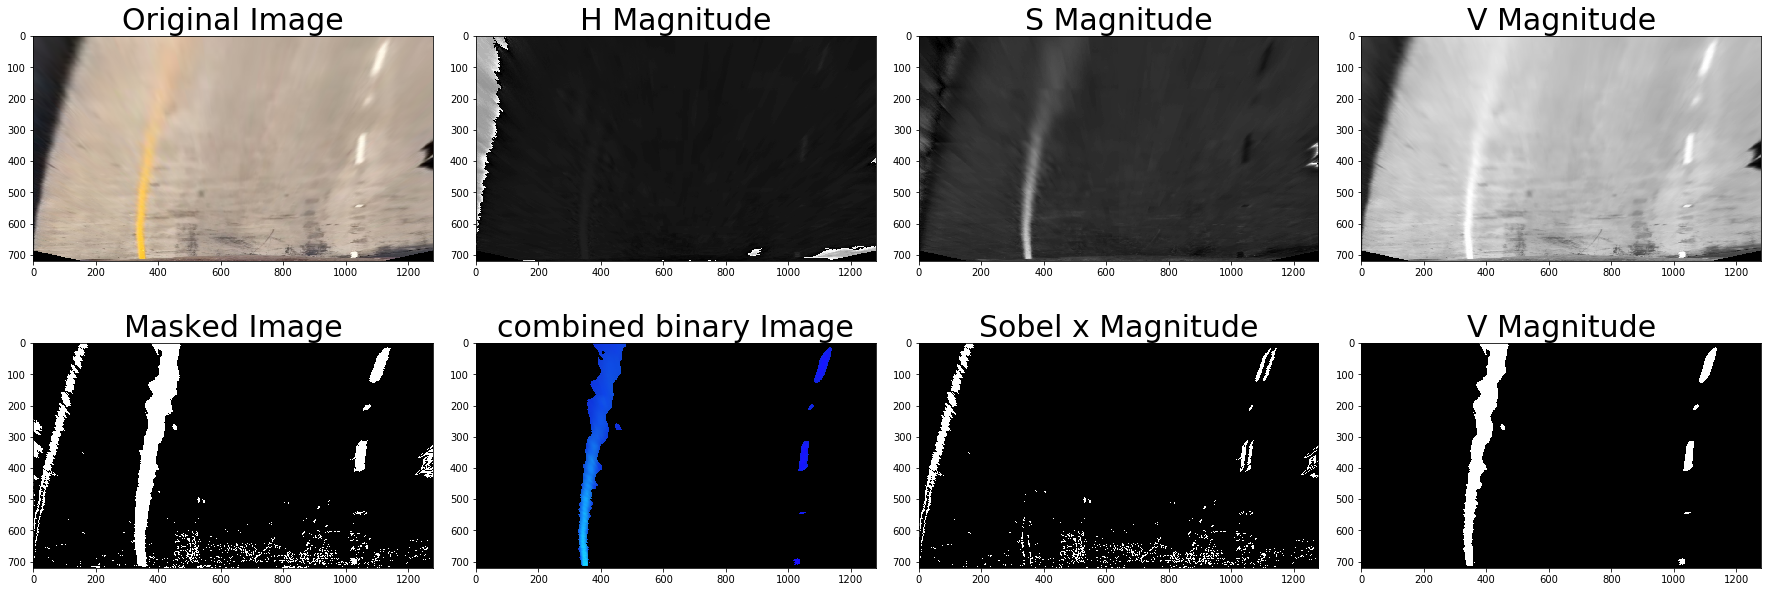

In [950]:
# Run the function
mag_binary = mag_thresh(perspective_img, sobel_kernel=9, mag_thresh=(30, 100))
# Plot the result
f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(perspective_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(H_img, cmap='gray')
ax2.set_title('H Magnitude', fontsize=30)
ax3.imshow(S_img, cmap='gray')
ax3.set_title('S Magnitude', fontsize=30)
ax4.imshow(V_img, cmap='gray')
ax4.set_title('V Magnitude', fontsize=30)

hsv_img = cv2.cvtColor(perspective_img, cv2.COLOR_RGB2HSV)  # cv2.cvtColor(perspective_img, cv2.COLOR_HSV2RGB)

# Sobel x
gray = cv2.cvtColor(perspective_img, cv2.COLOR_RGB2GRAY)
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 15
thresh_max = 40
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1



H_binary = np.zeros_like(H_img)

S_thresh = (70, 200)
S_binary = np.zeros_like(S_img)
S_binary[(S_img > S_thresh[0]) & (S_img <= S_thresh[1])] = 1

V_thresh = (220, 255)
V_binary = np.zeros_like(V_img)
V_binary[(V_img > V_thresh[0]) & (V_img <= V_thresh[1])] = 1

# (1) Combine the two binary thresholds
combined_binary = np.zeros_like(perspective_img[:,:,0])
combined_binary[(S_binary == 1) | (V_binary == 1) | (sxbinary == 1)] = 1

# (2) Colored combined image
filtered_hls_img = np.stack((H_binary, S_binary, V_binary), axis=2)

# (3)
lower_HSV = np.array([1, 1, 220])
upper_HSV = np.array([179, 255, 255])
mask_HSV = cv2.inRange(hsv_img, lower_HSV, upper_HSV)
mask_HSV_img = cv2.bitwise_and(hsv_img,hsv_img, mask= mask_HSV)


ax5.imshow(combined_binary*255, cmap='gray');ax5.set_title('Masked Image', fontsize=30);
ax6.imshow(mask_HSV_img, cmap='gray');ax6.set_title('combined binary Image', fontsize=30);
ax7.imshow(sxbinary, cmap='gray');ax7.set_title('Sobel x Magnitude', fontsize=30);
ax8.imshow(V_binary, cmap='gray');ax8.set_title('V Magnitude', fontsize=30);plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Line Finding Method: Peaks in a Histogram

In [885]:
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [961]:
gaussian_blur_combined_binary[gaussian_blur_combined_binary.shape[0]//2:,:].shape

(360, 1280)

Text(0.5,1,'gaussian blur histogram')

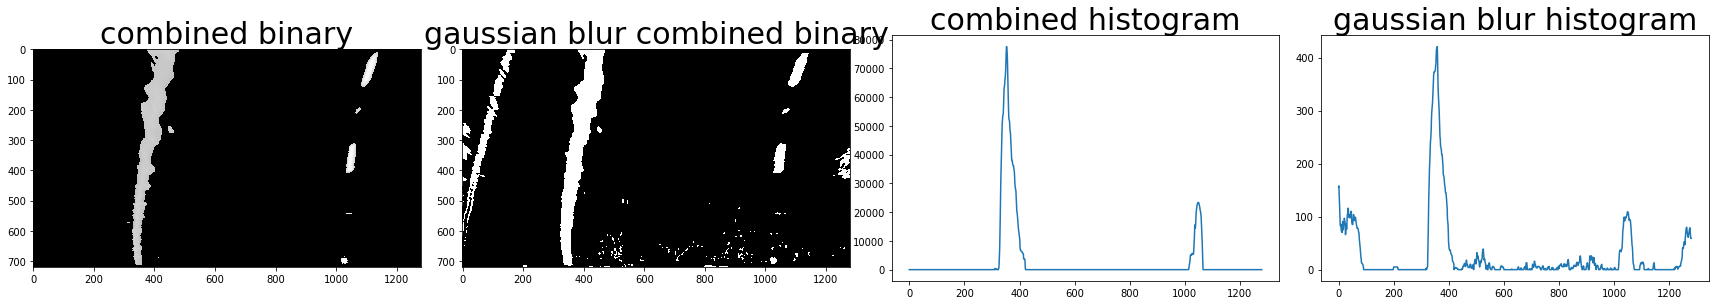

In [972]:
hsv_2_gray_img = cv2.cvtColor(mask_HSV_img, cv2.COLOR_HSV2RGB)
hsv_2_gray_img = cv2.cvtColor(hsv_2_gray_img, cv2.COLOR_RGB2GRAY)

gaussian_blur_combined_binary = gaussian_blur(combined_binary, 11)
combined_histogram = np.sum(hsv_2_gray_img[int(hsv_2_gray_img.shape[0]*0.4):,:], axis=0)

gaussian_blur_histogram = np.sum(gaussian_blur_combined_binary[int(gaussian_blur_combined_binary.shape[0]*0.4):,:], axis=0)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 4))
f.tight_layout()
ax1.imshow(hsv_2_gray_img, cmap='gray')
ax1.set_title('combined binary', fontsize=30)
ax2.imshow(gaussian_blur_combined_binary, cmap='gray')
ax2.set_title('gaussian blur combined binary', fontsize=30)
ax3.plot(combined_histogram)
ax3.set_title('combined histogram', fontsize=30)
ax4.plot(gaussian_blur_histogram)
ax4.set_title('gaussian blur histogram', fontsize=30)

### sliding window

In [983]:
binary_warped = hsv_2_gray_img 

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

In [984]:
# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

## visualization of sliding window

(720, 0)

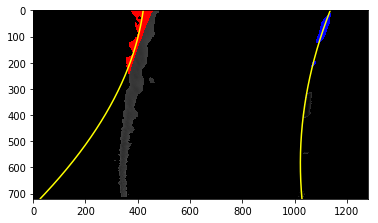

In [1002]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### visualize without sliding window

In [1000]:
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

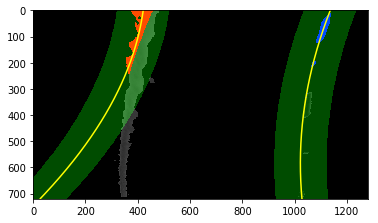

In [1001]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

The green shaded area shows where to search for the lines this time. 
Once you know where the lines are in one frame of video, you can do a highly targeted search for them in the next frame. This is equivalent to using a **customized region of interest** for each frame of video, and should help you track the lanes through sharp curves and tricky conditions. If you lose track of the lines, go back to the **sliding windows search** or other method (convolution for maximizing the number of "hot" pixels in each window.) to rediscover them.

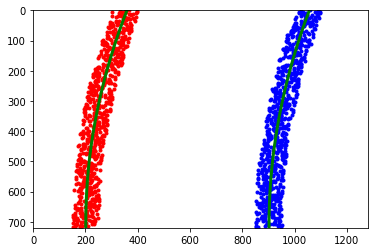

In [994]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

### curvature calculation
ref: https://www.intmath.com/applications-differentiation/8-radius-curvature.php

In [995]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

1569.23639103 1625.89346354


### converting x and y values to real world space.

your images with U.S. regulations that require a minimum lane width of 12 feet or 3.7 meters, and the dashed lane lines are 10 feet or 3 meters long each.

ref: http://onlinemanuals.txdot.gov/txdotmanuals/rdw/horizontal_alignment.htm#BGBHGEGC

In [996]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

515.335135311 m 533.989467465 m


In [846]:
perspective_img.shape
    new_fname = "..//contrast_enhanced_images//tileGridSize_"+ str(i)+".jpg"
    plt.imsave(fname = new_fname, arr =img ) 

IndentationError: unexpected indent (<ipython-input-846-7ce0618aeee9>, line 2)

## Test functions

In [150]:
def draw_polygon(img, pts, color = (255, 0, 0), thickness = 5):
    cp_img = np.copy(img)
    cv2.polylines(cp_img, [pts], True, color, thickness)
    return cp_img

In [124]:
def draw_circles(img, pts, radius = 20, color = [255, 0, 0], thickness = 5):
    cp_img = np.copy(img)
    for x,y in pts:
        cv2.circle(cp_img, (x,y), radius, color, thickness)
    return cp_img

In [148]:
imshape = img.shape
vertices = np.array([(.6*imshape[1], 0.6*imshape[0]), (imshape[1],imshape[0]),
                   (0,imshape[0]),(.4*imshape[1], 0.6*imshape[0])], dtype=np.int32)

In [ ]:
top_down, M = perspective_transform(img)

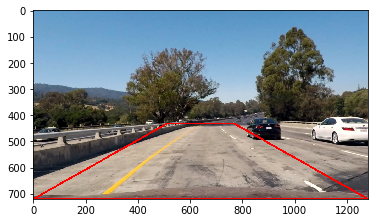

In [151]:
a= draw_polygon(undistorted, vertices)
plt.imshow(a)

[ 576.         453.6000061]
[ 576.         453.6000061]
[ 576.         453.6000061]
[ 576.         453.6000061]


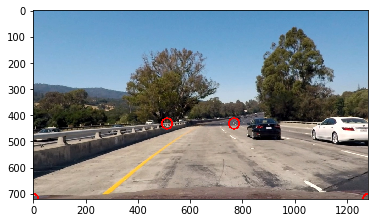

In [127]:
imshape = undistorted.shape
a= draw_circles(undistorted, vertices)
plt.imshow(a)

In [128]:
pts = np.array([[2, img.shape[0]-10], [img.shape[1]-5, img.shape[0]-10], [.55*img.shape[1], 0.625*img.shape[0]], [.45*img.shape[1], 0.625*img.shape[0]]], np.int32)
# cv2.polylines(img, [pts], True, (0,255,255), 3)

In [129]:
pts.shape

(4, 2)

In [250]:
class laneLineDetector:
    def __init__(self):
        """
        parameter for image processing
        """
        self.houghLine_para = { "rho": 1
                               , "theta": np.pi/180
                               , "threshold": 50
                               , "min_line_len": 100
                               , "max_line_gap": 160}

        self.canny_para = { "low_threshold": 50
                           , "high_threshold": 200}
        self.gaussian_blur_para = { "kernel_size": 7}
        
        """
        parameter from hough line filter
        """
        self.left_slope_upperbound = -0.2
        self.left_slope_lowerbound = -10.0

        self.right_slope_upperbound = 10.0
        self.right_slope_lowerbound = 0.2
        
        self.left_distance_upperbound = 300.0
        self.left_distance_lowerbound = 20.0 
        
        self.right_distance_upperbound = 300.0
        self.right_distance_lowerbound = 20.0
        
        """
        parameters for color filter
        """
        self.yellowLine_color_boundary = ([200,170,0], [255, 225, 150])
        self.WhiteLine_color_boundary = ([210,210,210], [255, 255, 255])

    def hough_lines(self, img, rho, theta, threshold, min_line_len, max_line_gap):
        """
        Generating Hough Lines for lane line detection 
        """        
        # The first and second row are the coordinates of left point. 
        # The first one is x_left, and the second one is y_left.
        # The third and fourth row are the coordinates of right point. 
        # The third one is x_right, and the fourth one is y_right.
        return np.squeeze(cv2.HoughLinesP(img, rho, theta
                                          , threshold, np.array([])
                                          , minLineLength=min_line_len
                                          , maxLineGap=max_line_gap), axis=1)

    def line_extrapolation(self):
        # compute line slope
        left_slope = np.divide(self.left_lines[1] - self.left_lines[3]
                               , self.left_lines[0] - self.left_lines[2])
        right_slope = np.divide(self.right_lines[1] - self.right_lines[3]
                                , self.right_lines[0] - self.right_lines[2])
                
        # capture fitting lane lines based on the slope average of Hough lines
        # do lane line extrapolation 
        Lane_Y_lowerbound = int(self.img.shape[0] * 0.63)
        Lane_Y_upperbound = self.img.shape[0]

        # the weight is the square of line length
        left_weight = np.sqrt(np.sum(np.square([self.left_lines[1] - self.left_lines[3]
                                                , self.left_lines[0] - self.left_lines[2]]), axis = 0))
        right_weight = np.sqrt(np.sum(np.square([self.right_lines[1] - self.right_lines[3]
                                                 , self.right_lines[0] - self.right_lines[2]]), axis = 0))
        
        left_weighted_slope = np.sum(left_weight * left_slope) / np.sum(left_weight)
        right_weighted_slope = np.sum(right_weight * right_slope) / np.sum(right_weight)

        left_masscenter = left_weight * self.left_lines
        right_masscenter = right_weight * self.right_lines
        
        # Assume mass center is (a,b) 
        # line formula: y-b = m * (x - a), m is slope
        # substitute Lane_Y_lowerbound, Lane_Y_upperbound into the equations 
        # and get Lane_X_lowerbound, Lane_X_upperbound
        
        left_weighted_masscenter = np.sum( np.stack((left_masscenter[0]+left_masscenter[2]
                                                     , left_masscenter[1]+left_masscenter[3])
                                                    , axis=0), axis=1) / (np.sum(left_weight, axis=0)* 2)
        right_weighted_masscenter = np.sum( np.stack((right_masscenter[0]+right_masscenter[2]
                                                      , right_masscenter[1]+right_masscenter[3])
                                                     , axis=0), axis=1) / (np.sum(right_weight, axis=0)* 2)
        
        # x = (y-b)/m + a
        return [((Lane_Y_upperbound - left_weighted_masscenter[1]) / left_weighted_slope 
                 + left_weighted_masscenter[0]
                 , Lane_Y_upperbound) # left_Lane_X_upperbound
                 ,((Lane_Y_lowerbound - left_weighted_masscenter[1]) / left_weighted_slope 
                   + left_weighted_masscenter[0]
                   , Lane_Y_lowerbound)  # left_Lane_X_lowerbound
                 ,((Lane_Y_upperbound - right_weighted_masscenter[1]) / right_weighted_slope 
                   + right_weighted_masscenter[0]
                   , Lane_Y_upperbound)  # right_Lane_X_upperbound
                 ,((Lane_Y_lowerbound - right_weighted_masscenter[1]) / right_weighted_slope 
                   + right_weighted_masscenter[0]
                   , Lane_Y_lowerbound)] # right_Lane_X_lowerbound
    
    def hough_line_filter(self, lines, distance_ftr = False):

        # calculate the slope and length of the lines for visualization
        self.slope = np.divide(lines[1]-lines[3], lines[0]-lines[2])
        right_condition = (self.slope >= self.right_slope_lowerbound)\
                            & (self.slope < self.right_slope_upperbound)
        left_condition = (self.slope >= self.left_slope_lowerbound)\
                            & (self.slope < self.left_slope_upperbound)
        
        """
        remove the lines which are too close to the region-of-interest boundary. 
        """
        if distance_ftr:
            left_vec_diff = self.reference_points_left[0] - self.reference_points_left[1]
            right_vec_diff= self.reference_points_right[0] - self.reference_points_right[1]        

            # Each line segment has two points, P1 and P2. 
            # The distance of the line to the boundary is 
            # the average of distance between P1 and boundary, P2 and boundary 
            P1 = lines[:2,:].T
            P2 = lines[2:4, :].T
            
            # if the slope is positive, the distance is P1 to right boundary. 
            # If negative, he distance is P1 to left boundary 
            distance_to_P1 = np.where( self.slope >=.0
                             , np.abs(np.cross(P1 - self.reference_points_right[0]
                                            , right_vec_diff)) / self.reference_points_distance
                             , np.abs(np.cross(P1 - self.reference_points_left[0]
                                            , left_vec_diff)) / self.reference_points_distance)

            # if the slope is positive, the distance is P2 to right boundary. 
            # if negative, he distance is P1 to left boundary 
            distance_to_P2 = np.where( self.slope >=.0
                             , np.abs(np.cross(P2 - self.reference_points_right[0]
                                            , right_vec_diff)) / self.reference_points_distance 
                             , np.abs(np.cross(P2 - self.reference_points_left[0]
                                            , left_vec_diff)) / self.reference_points_distance) 
            self.distance = (distance_to_P1 + distance_to_P2)/2
            
            # to know which side that line is located
            P1_Y = lines[1,:]     
            P1_X = lines[0,:]
            P2_Y = lines[3,:]    
            P2_X = lines[2,:]        
            
            side_of_P1 = np.where( self.slope >=.0
                             , P1_Y - self.reference_points_right[0][1] 
                                      - self.slope * (P1_X - self.reference_points_right[0][0])
                             , P1_Y - self.reference_points_left[0][1] 
                                      - self.slope * (P1_X - self.reference_points_left[0][0]))
            
            side_of_P2 = np.where( self.slope >=.0
                             , P2_Y - self.reference_points_right[0][1]
                                      - self.slope * (P2_X - self.reference_points_right[0][0])
                             , P2_Y - self.reference_points_left[0][1]
                                      - self.slope * (P2_X - self.reference_points_left[0][0]))
            
            
            right_condition = right_condition & ((side_of_P1 > 0) 
                                                 & (side_of_P2 > 0))
            left_condition = left_condition & ((side_of_P1 > 0) 
                                                 & (side_of_P2 > 0))
            
            right_condition = right_condition & ((self.distance >= self.right_distance_lowerbound) 
                                                 & (self.distance < self.right_distance_upperbound))
            left_condition = left_condition & ((self.distance >= self.left_distance_lowerbound) 
                                               & (self.distance < self.left_distance_upperbound))
        
        # there are two filters: 
        # filter based on slope and filter based on distance between 
        # detected Hough lines and boundaries. 
        
        # right lines filters: 
        self.right_lines = (lines[:,np.array(right_condition)])

        # left lines filter: 
        self.left_lines = (lines[:,np.array(left_condition)])
        
        # if no line was picked after filtering, 
        # then pick line of the smallest slope for left line 
        # and line of the largest slope for right line
        if self.left_lines.shape[1] == 0:
            self.left_lines = lines[:,np.argmin(self.slope)].reshape(4,1)    
        if self.right_lines.shape[1] == 0:
            self.right_lines = lines[:,np.argmax(self.slope)].reshape(4,1)

        return self.right_lines, self.left_lines

    def grayscale(self, img):
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    def canny(self, img, low_threshold, high_threshold):
        return cv2.Canny(img, low_threshold, high_threshold)

    def gaussian_blur(self, img, kernel_size):
        return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

    def region_of_interest(self, img, vertices):
        mask = np.zeros_like(img)   
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        cv2.fillPoly(mask, vertices, ignore_mask_color)

        masked_image = cv2.bitwise_and(img, mask)
        return masked_image

    def weighted_img(self, initial_img, img, α=1.0, β=0.8, λ=0.):
        """
        initial_img * α + img * β + λ
        """
        return cv2.addWeighted(initial_img, α, img, β, λ)

    def get_fitLineCharacter(self, x, y):
        """
        format is y = slope * x + intercept
        """
        slope, intercept, _, _, std_err = stats.linregress(x,y)
        return slope, intercept

    def draw_lines(self, img, lines, color=[255, 0, 0], thickness=10):
        for x1, y1, x2, y2 in lines:
            cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)

    def draw_circle(self, img, center, radius, color, thickness = 5):
        cv2.circle(img, center, radius, color, thickness)

    def draw_triangle(self, img, vertex, color, thickness = 5):
        cv2.polylines(img, [vertex], True, color,thickness)
        
    def viz_line_features(self):
        """
        visualize the distribution of Hough line features
        """
        line_num = self.slope.shape[0]
        
        self.slope = np.reshape(self.slope, (1, line_num))
        self.distance = np.reshape(self.distance, (1, line_num))
            
        input_scatterPlot = np.concatenate((self.slope.T
                                            , self.distance.T), axis=1)    
        
        dataframe = pd.DataFrame(input_scatterPlot, columns=['Slope', 'Distance'])

        dataframe['lineSign'] = pd.Series(np.squeeze(np.where(self.slope >=.0
                                                              , 'right'
                                                              , 'left'), axis=0))
        fig = ff.create_scatterplotmatrix(dataframe
                                          , diag='histogram'
                                          , index='lineSign'
                                          , height=800, width=800)
        plotly.offline.iplot(fig, filename='Box plots along Diagonal Subplots')

    def point_to_line_distance(self, A, B, P):
        """ 
        segment line AB, point P, where each one is an array([x, y]) 
        the angle lies in [-pi/2, pi/2].
        """
        if (A==B).all():
            return norm(P - A)
        else :
            return abs(np.cross(P - B, A - B) / norm(A - B))

    def show_img(self, img):
        cv2.namedWindow("Image")   
        cv2.imshow("Image", img)
        cv2.waitKey (0)  
        cv2.destroyAllWindows()  

    def color_of_interest(self, img, boundary):
        lower, upper = boundary
        # create NumPy arrays from the boundaries
        lower = np.array(lower, dtype = "uint8")
        upper = np.array(upper, dtype = "uint8")

        # find the colors within the specified boundaries and apply
        # the mask
        mask = cv2.inRange(img, lower, upper)
        return cv2.bitwise_and(img, self.img,  mask= mask)
        
    def plot_color_distribution(self, elements, color, _alpha = 0.5, _size = 5, _dpi = 96, dim ='RB'):

        color_dict = {'R':0, 'G':1, 'B':2}
        color1 = color_dict[dim[0]]
        color2 = color_dict[dim[1]]

        plt.figure(figsize=(500/_dpi, 500/_dpi), dpi=_dpi)
        plt.axis([0, 1, 0, 1])
        plt.axes([0.0, 0.0, 1, 1])
        plt.scatter(elements[:,color1],elements[:,color2], s=_size, c=color, alpha=_alpha)
        
        plt.xlabel(dim[0])
        plt.ylabel(dim[1])
        plt.title(dim + ' distribution')

        plt.xlim(min(elements[:,color1]), max(elements[:,color1]))
        plt.ylim(min(elements[:,color2]), max(elements[:,color2]))
        
        plt.savefig('color_distribution//'+dim+'_distribution.png')
        return
           
    def color_filterprocess_image(self, img):
        """
        the main pipeline for lane line detection
        """
        self.img = img
        self.img_size = img.shape

        
        # points for calculating the point-to-line distance
        # np.array([[480, 270], [960, 540]])
        self.reference_points_right = np.array([[self.img_size[1]//2, self.img_size[0]//2]
                                                , [self.img_size[1], self.img_size[0]]])        
        # np.array([[480, 270], [0, 540]])   
        self.reference_points_left = np.array([[self.img_size[1]//2, self.img_size[0]//2]
                                               , [0 ,self.img_size[0]]])                                      
        self.reference_points_distance = norm(self.reference_points_right[0] 
                                              - self.reference_points_right[1])   
        
        
        # points for fetching region of interest
        self.auxiliary_points = np.array([[(0,self.img_size[0])
                                           ,(self.img_size[1]//2, self.img_size[0]//2)
                                           , (self.img_size[1],self.img_size[0])]], dtype=np.int32)
        
        # capture the region of interest
        self.masked_img = self.region_of_interest(self.img, self.auxiliary_points)
        
        # tranform image from (height, width, 3) to (height * width, 3)
        self.non_black_elements = self.masked_img[self.masked_img.any(axis=-1)]  
        self.color = self.non_black_elements/255
        self.yellowLine_img = self.color_of_interest(self.masked_img, self.yellowLine_color_boundary)
        self.whiteLine_img = self.color_of_interest(self.masked_img, self.WhiteLine_color_boundary)
        
        self.blend_img = self.weighted_img(self.yellowLine_img, self.whiteLine_img)        
        
        # output an image with only one color channel
        self.gray_image = self.grayscale(self.blend_img)
#         self.sharpened_img = np.where(self.gray_image > 0, 255, 0) 
        
        # canny transformation
        self.canny_img = self.canny(self.gray_image
                                    , self.canny_para["low_threshold"]
                                    , self.canny_para["high_threshold"])
        
        # filter for Gaussian smoothing 
        self.gaussian_blur_para = { "kernel_size": 5}
        self.blurred_img = self.gaussian_blur(self.canny_img, self.gaussian_blur_para["kernel_size"])

        # hough line generation
        self.houghLines = self.hough_lines(self.blurred_img
                                   , self.houghLine_para["rho"]
                                   , self.houghLine_para["theta"]
                                   , self.houghLine_para["threshold"]
                                   , self.houghLine_para["min_line_len"]
                                   , self.houghLine_para["max_line_gap"]) 
        
        # separate Hough lines into left lines and right lines. 
        # search (1) the leftmost point of right Hough lines and 
        # (2) the rightmost point of left Hough lines
        self.right_lines, self.left_lines = self.hough_line_filter(self.houghLines.T,True)
        [(left_upper_x1,left_upper_y1)
         , (left_lower_x1,left_lower_y1)
         , (right_upper_x1,right_upper_y1)
         , (right_lower_x1,right_lower_y1)] = self.line_extrapolation()
        
        # source points for perspective transformation
        self.src_pts = np.array([(left_upper_x1,left_upper_y1)
                        , (right_upper_x1,right_upper_y1)
                        , (right_lower_x1,right_lower_y1)
                        , (left_lower_x1,left_lower_y1)], dtype=np.float32)
        
        # draw lane lines after extrapolation 
        out_img = np.copy(self.img)
        self.draw_lines(out_img
                        , [[left_upper_x1,left_upper_y1, left_lower_x1,left_lower_y1]
                        ,[right_upper_x1,right_upper_y1, right_lower_x1,right_lower_y1]]
                        ,color=[255, 0, 0]
                        , thickness=10)

        return out_img

In [241]:
from numpy.linalg import det, norm

In [242]:
color_selector_obj = laneLineDetector()
cp_img = np.copy(undistorted)
out_image = color_selector_obj.color_filterprocess_image(cp_img)

In [ ]:
### convolution for hot pixel

In [ ]:
ax1.imshow(hsv_2_gray_img, cmap='gray')
ax1.set_title('combined binary', fontsize=30)
ax2.imshow(gaussian_blur_combined_binary, cmap='gray')

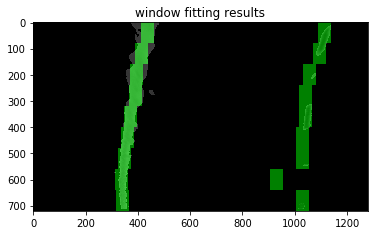

In [993]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
warped = hsv_2_gray_img
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,image.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,image.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
	    l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
	    r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
	    # Add graphic points from window mask here to total pixels found 
	    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
	    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()